cuda:0


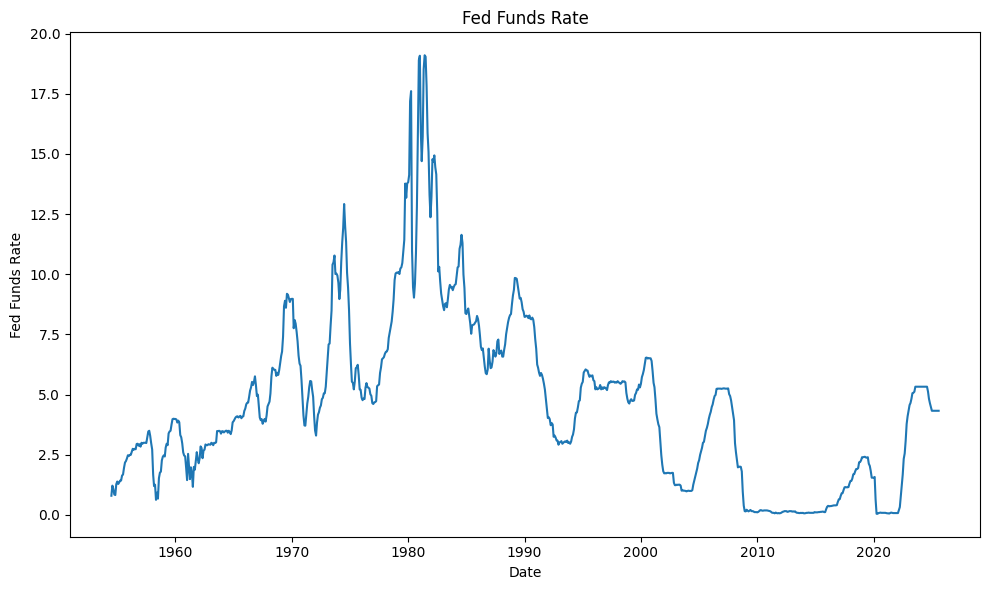

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import fredapi.fred as fr
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error
from dotenv import load_dotenv
import os
load_dotenv()
FRED_API_KEY = os.getenv("FRED_API_KEY")


fred = fr.Fred(FRED_API_KEY)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

# fed funds rate

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']


data.drop("index",axis=1,inplace=True)


plt.figure(figsize=(10,6))
sns.lineplot(x=data['Date'],y=data['Fed Funds Rate'])
plt.title("Fed Funds Rate")
plt.tight_layout()
plt.savefig("images/fed-funds-rate")
plt.show()


In [2]:
data.head(10)

,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [3]:
#training
training = data.iloc[:,0:1].values



train_split = int(len(training) * .80)
train_data = training[:train_split]
test_data = training[train_split:]
print(f' Shape of training data: {train_data.shape}')
print(f' Shape of testing data: {test_data.shape}')

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1

X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0, c0))
        out = self.fc(out[:,-1,:])
        return out



bidirectional_lstm = BiLSTM(input_size=1,hidden_size=256,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

 Shape of training data: (683, 1)
 Shape of testing data: (171, 1)


In [4]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')
        

/tmp/ipykernel_57303/1334293925.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_57303/1334293925.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.299; Test RMSE: 0.1019
Epoch: 1; train_RMSE: 0.2753; Test RMSE: 0.0961
Epoch: 2; train_RMSE: 0.2522; Test RMSE: 0.09918
Epoch: 3; train_RMSE: 0.2298; Test RMSE: 0.1114
Epoch: 4; train_RMSE: 0.2089; Test RMSE: 0.1316
Epoch: 5; train_RMSE: 0.191; Test RMSE: 0.1578
Epoch: 6; train_RMSE: 0.1784; Test RMSE: 0.1883
Epoch: 7; train_RMSE: 0.1733; Test RMSE: 0.2212
Epoch: 8; train_RMSE: 0.1764; Test RMSE: 0.2533
Epoch: 9; train_RMSE: 0.1842; Test RMSE: 0.2796
Epoch: 10; train_RMSE: 0.1911; Test RMSE: 0.2959
Epoch: 11; train_RMSE: 0.1937; Test RMSE: 0.3014
Epoch: 12; train_RMSE: 0.1915; Test RMSE: 0.2978
Epoch: 13; train_RMSE: 0.186; Test RMSE: 0.2875
Epoch: 14; train_RMSE: 0.179; Test RMSE: 0.273
Epoch: 15; train_RMSE: 0.1722; Test RMSE: 0.2564
Epoch: 16; train_RMSE: 0.1668; Test RMSE: 0.2392
Epoch: 17; train_RMSE: 0.1633; Test RMSE: 0.2226
Epoch: 18; train_RMSE: 0.1615; Test RMSE: 0.2077
Epoch: 19; train_RMSE: 0.1611; Test RMSE: 0.1947
Epoch: 20; train_RMSE: 0.1613; Tes

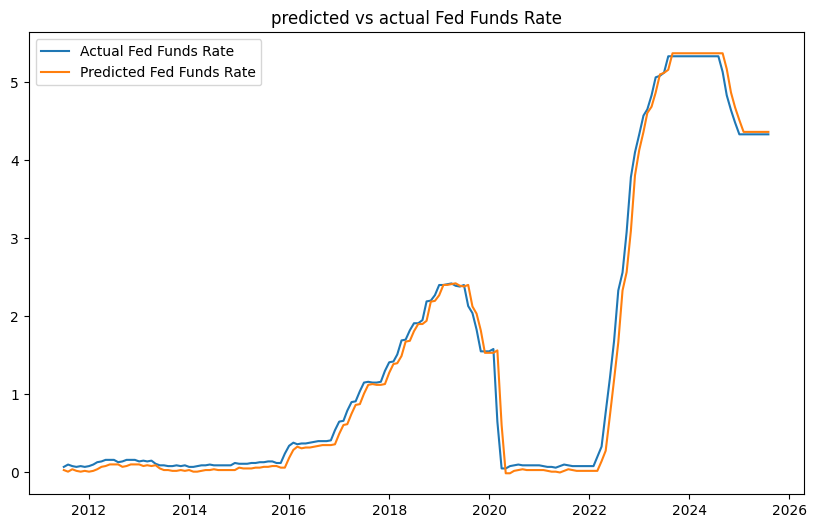

In [5]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)




test_dates = data.iloc[train_split + seq_length:]['Date']

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Fed Funds Rate")
plt.legend()
plt.savefig("images/Predicted-Actual-Fed-Funds-Rate.png")
plt.show()

In [6]:
# Root Mean-Squared Error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f'Root Mean-Squared Error: {rmse:.4}')

# R2 Score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:.2f}%')

# mean absolute percentage error
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Absolute Percentage Error: {mape:.4f}')




print(comparison_df.head(20))
print(comparison_df.tail(20))

Root Mean-Squared Error: 0.1664
R2 Score: 99.18%
Mean Absolute Percentage Error: 0.4118
          Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
684 2011-07-01                   0.07                  0.029438
685 2011-08-01                   0.10                  0.008798
686 2011-09-01                   0.08                  0.039758
687 2011-10-01                   0.07                  0.019119
688 2011-11-01                   0.08                  0.008798
689 2011-12-01                   0.07                  0.019119
690 2012-01-01                   0.08                  0.008798
691 2012-02-01                   0.10                  0.019119
692 2012-03-01                   0.13                  0.039758
693 2012-04-01                   0.14                  0.070713
694 2012-05-01                   0.16                  0.081031
695 2012-06-01                   0.16                  0.101665
696 2012-07-01                   0.16                  0.101665
697 2012-08-01  